In [1]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps, get_scipy_selected_stumps
from evaluation import central_train_accuracy, central_test_accuracy, edges, central_loss, random_accuracy, maj_class_accuracy, best_accuracy
from network import graph
from related_works import colearning, lafond_FW
from optimization import regularized_local_FW, local_FW, global_regularized_local_FW, gd_reg_local_FW, centralized_FW
from utils import load_school, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set graph of nodes with local personalized data
NB_ITER = 5000
n = 85

MU = 1
BETA = 1

X, Y, X_test, Y_test, adjacency, distances, K, max_nb_instances = load_school(path="../datasets/", thr=20)
D = X[0].shape[1]

# get nodes
nodes = graph(X, Y, X_test, Y_test, K, adjacency, distances, max_nb_instances)

# set monitors for optimization analysis
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D, min_v=vmin, max_v=vmax)

results = {}

In [ ]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["Global-Adaboost"] = {}
results["Global-Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["Global-Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["Local-Adaboost"] = {}
results["Local-Adaboost"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["Local-Adaboost"]["test-accuracy"] = central_test_accuracy(local_nodes)

In [4]:
results["Perso-linear-Fixed"], clf_colearning = colearning(K, X, Y, X_test, Y_test, D, NB_ITER, adjacency, 
                                    distances, mu=10, max_samples_per_node=max_nb_instances, checkevery=100)

In [5]:
reg_nodes = deepcopy(nodes)
results["Dada-Fixed"] = regularized_local_FW(reg_nodes, base_clfs, nb_iter=NB_ITER, beta=BETA, mu=MU, monitors=monitors, checkevery=100)

In [6]:
# initialize with local models
MU, LA = 1, 0.001
STEP = 1000
gd_nodes = deepcopy(nodes)
results["Dada-Learned"] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": STEP, 
                        "args":(MU, LA)}, beta=BETA, mu=MU, nb_iter=NB_ITER, monitors=monitors, checkevery=100)

# Accuracy and Convergence

purely local models 0.741260570133
global l1 Adaboost 0.697236509459


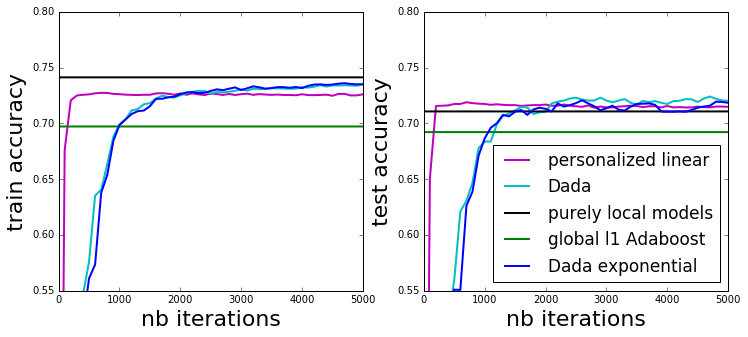

In [14]:
colors = {
    "Global-Adaboost": "g",
    "Local-Adaboost": "k",
    "Dada-Fixed": "b",
    "Perso-linear-Fixed": "m", 
    "Dada-Learned": "c",    
    "Dada-Random": "r",
}

plt.figure(1, figsize=(12, 5))

max_iter = NB_ITER
plt.subplot(121)
plt.xlabel('nb iterations', fontsize=15)
plt.ylabel('train accuracy', fontsize=15)
plt.xlim(0, max_iter)
plt.ylim(0.6, 0.75)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

for k, r_list in results.items():
    label = k
    if k.startswith("Dada"):
        label = '_nolegend_'
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label=label, color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['train-accuracy']]*(NB_ITER+1), label=label, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=15)

plt.subplot(122)
plt.xlabel('nb iterations', fontsize=15)
plt.ylabel('test accuracy', fontsize=15)
plt.xlim(0, max_iter)
plt.ylim(0.6, 0.75)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

for k, r_list in results.items():
    label = '_nolegend_'
    if k.startswith("Dada"):
        label = '{}'.format(k)
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label=label, color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['test-accuracy']]*(NB_ITER+1), label=label, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=15)

plt.savefig("school-acc.pdf", bbox_inches="tight")

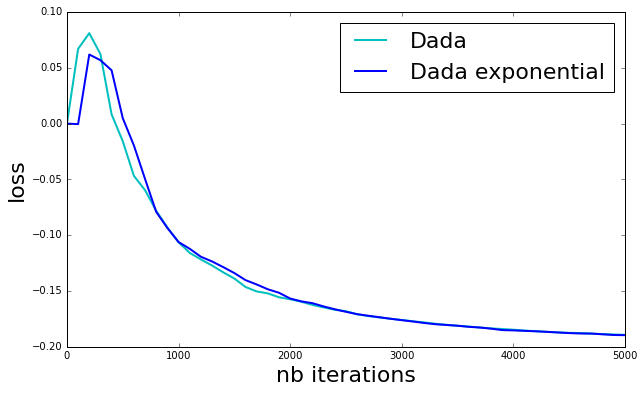

In [8]:
# convergence
plt.figure(1, figsize=(10, 6))

plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('loss', fontsize=22)

for k, r_list in results.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['loss'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        pass

plt.legend(loc='upper right', fontsize=22)

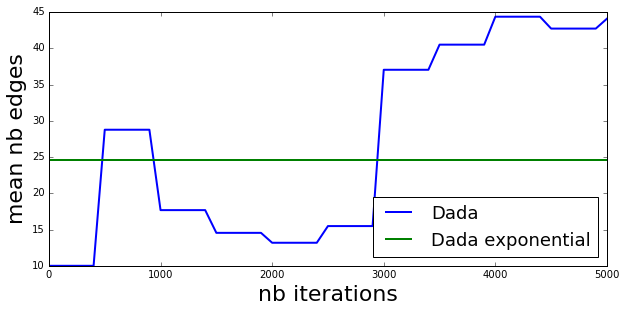

In [9]:
max_iter = 5000

plt.figure(1, figsize=(10, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('mean nb edges', fontsize=22)
plt.xlim(0, max_iter)
# plt.ylim(0.4, 1)

for k, r_list in results.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [np.mean(r['edges']) for r in r_list], label='{}'.format(k), linewidth=2)
    except:
        pass

plt.legend(loc='lower right', fontsize=18)